In [1]:
import arviz as az
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pickle
import scipy.stats as st
from statsmodels.formula.api import ols
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()
BTR = importr('bayestestR')
BF = importr('BayesFactor')

mpl.rcParams['font.size'] = 20

In [3]:
az_dict = {} # create a dicitonary of all netcdf Stan model outputs
df_dict = {} # create a dictionary of all csvs containing d-scores and explicit preferences
n_dict = {} # create a dictionary of total sample sizes for each IAT (every subject that went into group-level parameters in model, not just those with subject-level estimates)
for x in ['possiblecertain', 'labormanagement', 'statechurch', 'socialismcapitalism', 'complexsimple', 'protestaccept',
          'fairbiased', 'democracyfascism', 'motherfather', 'hopeduty', 'selfother', 'regulationmarkets',
          'progressrestore', 'newold', 'non-profitscorporations', '20501950', 'ambiguousclear',
          'defendattack', 'changepreserve', 'collectiveindividual', 'communityindividual', 'individualgroup',
          'forwardbackward', 'equalunequal', 'anarchyhierarchy', 'justiceinjustice',
          'novelfamiliar', 'foreignlocal', 'nurturingstrict',
          'presentpast', 'blackwhite', 'gaystraight', 'riskycautious', 'futurepresent', '20501950_ds', 
          'dangersafety_tf', 'sciencereligion_tf', 'conspiracyaccident_tf', 'evolutioncreationism_tf', 'self_dr',
          'self_ar', 'self_lc', 'self_sa']:
    try:
        az_dict[x] = az.from_netcdf('raceddm_%s.nc' % x)
        df_dict[x] = pd.read_csv('%s.csv' % x)
        with open('%s.pkl' % x, 'rb') as f:
            data = pickle.load(f)
        n_dict[x] = data['N']
    except:
        pass

In [4]:
# make a dictionary with keys for each IAT, and all RDM thresholds for "Action B". Four different thresholds for four different blocks.
accumulator_b_dict = {'20501950_ds': ['2050', 'Safety', '2050/Safety', '1950/Safety'],
                   '20501950': ['1950', 'Bad', '1950/Bad', '2050/Bad'],
                   'ambiguousclear': ['Ambiguous', 'Bad', 'Ambiguous/Bad', 'Clear/Bad'],
                   'anarchyhierarchy': ['Anarchy', 'Bad', 'Anarchy/Bad', 'Hierarchy/Bad'],
                   'changepreserve': ['Preserve', 'Bad', 'Preserve/Bad', 'Change/Bad'],
                   'communityindividual': ['Individual', 'Bad', 'Individual/Bad', 'Community/Bad'],
                  'collectiveindividual': ['Individual', 'Bad', 'Individual/Bad', 'Collective/Bad'],
                  'conspiracyaccident_tf': ['Conspiracy', 'False', 'Conspiracy/False', 'Accident/False'],
                  'defendattack': ['Attack', 'Bad', 'Attack/Bad', 'Defend/Bad'],
                  'equalunequal': ['Unequal', 'Bad', 'Unequal/Bad', 'Equal/Bad'],
                  'evolutioncreationism_tf': ['Creationism', 'False', 'Creationism/False', 'Evolution/False'],
                  'foreignlocal': ['Foreign', 'Bad', 'Foreign/Bad', 'Local/Bad'],
                  'forwardbackward': ['Backward', 'Bad', 'Backward/Bad', 'Forward/Bad'],
                  'futurepresent': ['Future', 'Bad', 'Future/Bad', 'Present/Bad'],
                  'hopeduty': ['Duty', 'Bad', 'Duty/Bad', 'Hope/Bad'],
                  'individualgroup': ['Group', 'Bad', 'Group/Bad', 'Individual/Bad'],
                  'justiceinjustice': ['Injustice', 'Bad', 'Injustice/Bad', 'Justice/Bad'],
                  'motherfather': ['Father', 'Bad', 'Father/Bad', 'Mother/Bad'],
                  'newold': ['Old', 'Bad', 'Old/Bad', 'New/Bad'],
                  'non-profitscorporations': ['Corporations', 'Bad', 'Corporations/Bad', 'Non-Profits/Bad'],
                  'novelfamiliar': ['Novel', 'Bad', 'Novel/Bad', 'Familiar/Bad'],
                  'nurturingstrict': ['Strict', 'Bad', 'Strict/Bad', 'Nurturing/Bad'],
                  'presentpast': ['Past', 'Bad', 'Past/Bad', 'Present/Bad'],
                  'progressrestore': ['Restore', 'Bad', 'Restore/Bad', 'Progress/Bad'],
                  'regulationmarkets': ['Regulation', 'Bad', 'Regulation/Bad', 'Markets/Bad'],
                  'sciencereligion_tf': ['Religion', 'False', 'Religion/False', 'Science/False'],
                  'blackwhite': ['Black People', 'Bad', 'Black People/Bad', 'White People/Bad'],
                  'gaystraight': ['Gay People', 'Bad', 'Gay People/Bad', 'Straight People/Bad'],
                  'riskycautious': ['Risky', 'Bad', 'Risky/Bad', 'Cautious/Bad'],
                  'possiblecertain': ['Possible', 'Bad', 'Possible/Bad', 'Certain/Bad'],
                  'labormanagement': ['Labor', 'Bad', 'Labor/Bad', 'Management/Bad'],
                  'statechurch': ['State', 'Bad', 'State/Bad', 'Church/Bad'],
                  'socialismcapitalism': ['Socialism', 'Bad', 'Socialism/Bad', 'Capitalism/Bad'],
                  'complexsimple': ['Complex', 'Bad', 'Complex/Bad', 'Simple/Bad'],
                  'protestaccept': ['Protest', 'Bad', 'Protest/Bad', 'Accept/Bad'],
                  'fairbiased': ['Biased', 'Bad', 'Biased/Bad', 'Fair/Bad'],
                  'democracyfascism': ['Fascism', 'Bad', 'Fascism/Bad', 'Democracy/Bad'],
                  'dangersafety_tf': ['Danger', 'False', 'Danger/False', 'Safety/False'],
                  'selfother': ['Other', 'Bad', 'Other/Bad', 'Self/Bad'],
                  'self_ar': ['Atheist', 'Atheist/Self'],
                  'self_dr': ['Republican', 'Republican/Self'],
                  'self_lc': ['Conservative', 'Conservative/Self'],
                  'self_sa': ['Anger', 'Anger/Self']}

# make a dictionary of blocks with keys for each IAT. Blocks are recorded as integers for Stan to use as indices. 
# concept-only block = 1, attribute-only block = 2, compatible block = 3, incompatible block = 4
# for single-target IATs, concept-only block = 2, compatible block = 3, incompatible block = 4
block_dict = {}
for y in list(df_dict.keys()):
      tempdict = {}
      if len(accumulator_b_dict[y]) == 4 and y!='clintonbush_ch':
            x = accumulator_b_dict[y]
            tempdict['%s,%s' % (x[0],x[3].split('/')[0])] = 1
            tempdict['%s,%s' % (x[3].split('/')[0],x[0])] = 1
            if x[1] == 'Bad':
                  tempdict['Good,Bad'] = 2
                  tempdict['%s/Good,%s' % (x[3].split('/')[0], x[2])] = 3
                  tempdict['%s/Good,%s' % (x[0], x[3])] = 4
            elif x[1] == 'False':
                  tempdict['True,False'] = 2
                  tempdict['%s/True,%s' % (x[3].split('/')[0], x[2])] = 3
                  tempdict['%s/True,%s' % (x[0], x[3])] = 4
            elif x[1] == 'Safety':
                  tempdict['Danger,Safety'] = 2
                  tempdict['%s/Danger,%s' % (x[3].split('/')[0], x[2])] = 3
                  tempdict['%s/Danger,%s' % (x[0], x[3])] = 4
            block_dict[y] = tempdict
      elif len(accumulator_b_dict[y]) == 2:
            if y == 'self_ar':
                  tempdict['Atheist,Religious'] = 2
                  tempdict['Atheist,Religious/Self'] = 3
                  tempdict['Atheist/Self,Religious'] = 4
            if y == 'self_dr':
                  tempdict['Democrat,Republican'] = 2
                  tempdict['Democrat/Self,Republican'] = 3
                  tempdict['Democrat,Republican/Self'] = 4
            if y == 'self_lc':
                  tempdict['Liberal,Conservative'] = 2
                  tempdict['Liberal/Self,Conservative'] = 3
                  tempdict['Liberal,Conservative/Self'] = 4
            if y == 'self_sa':
                  tempdict['Sadness,Anger'] = 2
                  tempdict['Sadness/Self,Anger'] = 3
                  tempdict['Sadness,Anger/Self'] = 4
            block_dict[y] = tempdict

# ticks for figures
xticks = {'blackwhite': 'Race (X=Black, Y=White)',
          'gaystraight': 'Sexuality (X=Gay, Y=Straight)',
          'statechurch': 'Secularity (X=State, Y=Church)',
          'labormanagement': 'Employment (X=Labor, Y=Management)',
          'protestaccept': 'Protest (X=Protest, Y=Accept)',
          'socialismcapitalism': 'Economic Systems (X=Socialism, Y=Capitalism)',
          'complexsimple': 'Complexity (X=Complex, Y=Simple)',
          'fairbiased': 'Fairness (X=Biased, Y=Fair)',
          'democracyfascism': 'Government Systems (X=Fascism, Y=Democracy)',
          'motherfather': 'Parents (X=Father, Y=Mother)',
          '20501950_ds': 'Centuries-Danger (X=2050, Y=1950)',
          '20501950': 'Centuries (X=1950, Y=2050)',
          'anarchyhierarchy': 'Order (X=Anarchy, Y=Hierarchy)',
          'ambiguousclear': 'Clarity (X=Ambiguous, Y=Clear)',
          'changepreserve': 'Preservation (X=Preserve, Y=Change)',
          'clintonbush_ch': 'Presidents-Corruption (X=Bill Clinton, Y=George Bush)',
          'communityindividual': 'Cultural Ideology II (X=Individual, Y=Community)',
          'collectiveindividual': 'Cultural Ideology I (X=Individual, Y=Collective)',
          'conspiracyaccident_tf': 'Explanations-Truth (X=Conspiracy, Y=Accident)',
          'defendattack': 'Strategy (X=Attack, Y=Defend)',
          'equalunequal': 'Equality (X=Unequal, Y=Equal)',
          'evolutioncreationism_tf': 'Origins-Truth (X=Creationism, Y=Evolution)',
          'foreignlocal': 'Location (X=Foreign, Y=Local)',
          'forwardbackward': 'Direction (X=Backward, Y=Forward)',
          'futurepresent': 'Time I (X=Future, Y=Present)',
          'hopeduty': 'Goals (X=Duty, Y=Hope)',
          'individualgroup': 'Cultural Ideology III (X=Group, Y=Individual)',
          'justiceinjustice': 'Justice (X=Injustice, Y=Justice)',
          'newold': 'Age (X=Old, Y=New)',
          'non-profitscorporations': 'Businesses (X=Corporations, Y=Non-Profits)',
          'novelfamiliar': 'Novelty (X=Novel, Y=Familiar)',
          'nurturingstrict': 'Parenting (X=Strict, Y=Nurturing)',
          'presentpast': 'Time II (X=Past, Y=Present)',
          'progressrestore': 'Steps (X=Restore, Y=Progress)',
          'regulationmarkets': 'Economic Policy (X=Regulation, Y=Markets)',
          'sciencereligion_tf': 'Philosophies-Truth (X=Religion, Y=Science)',
          'riskycautious': 'Risk (X=Risky, Y=Cautious)',
          'possiblecertain': 'Likelihood (X=Possible, Y=Certain)',
          'dangersafety_tf': 'Threat-Truth (X=Danger, Y=Safety)',
          'selfother': 'Identity (X=Other, Y=Self)',
          'self_dr': 'Self-Political Affiliation (X=Republican, Y=Democrat)',
          'self_ar': 'Self-Religiosity (X=Atheist, Y=Religious)',
          'self_lc': 'Self-Political Ideology (X=Conservative, Y=Liberal)',
          'self_sa': 'Self-Emotionality (X=Anger, Y=Sadness)'}

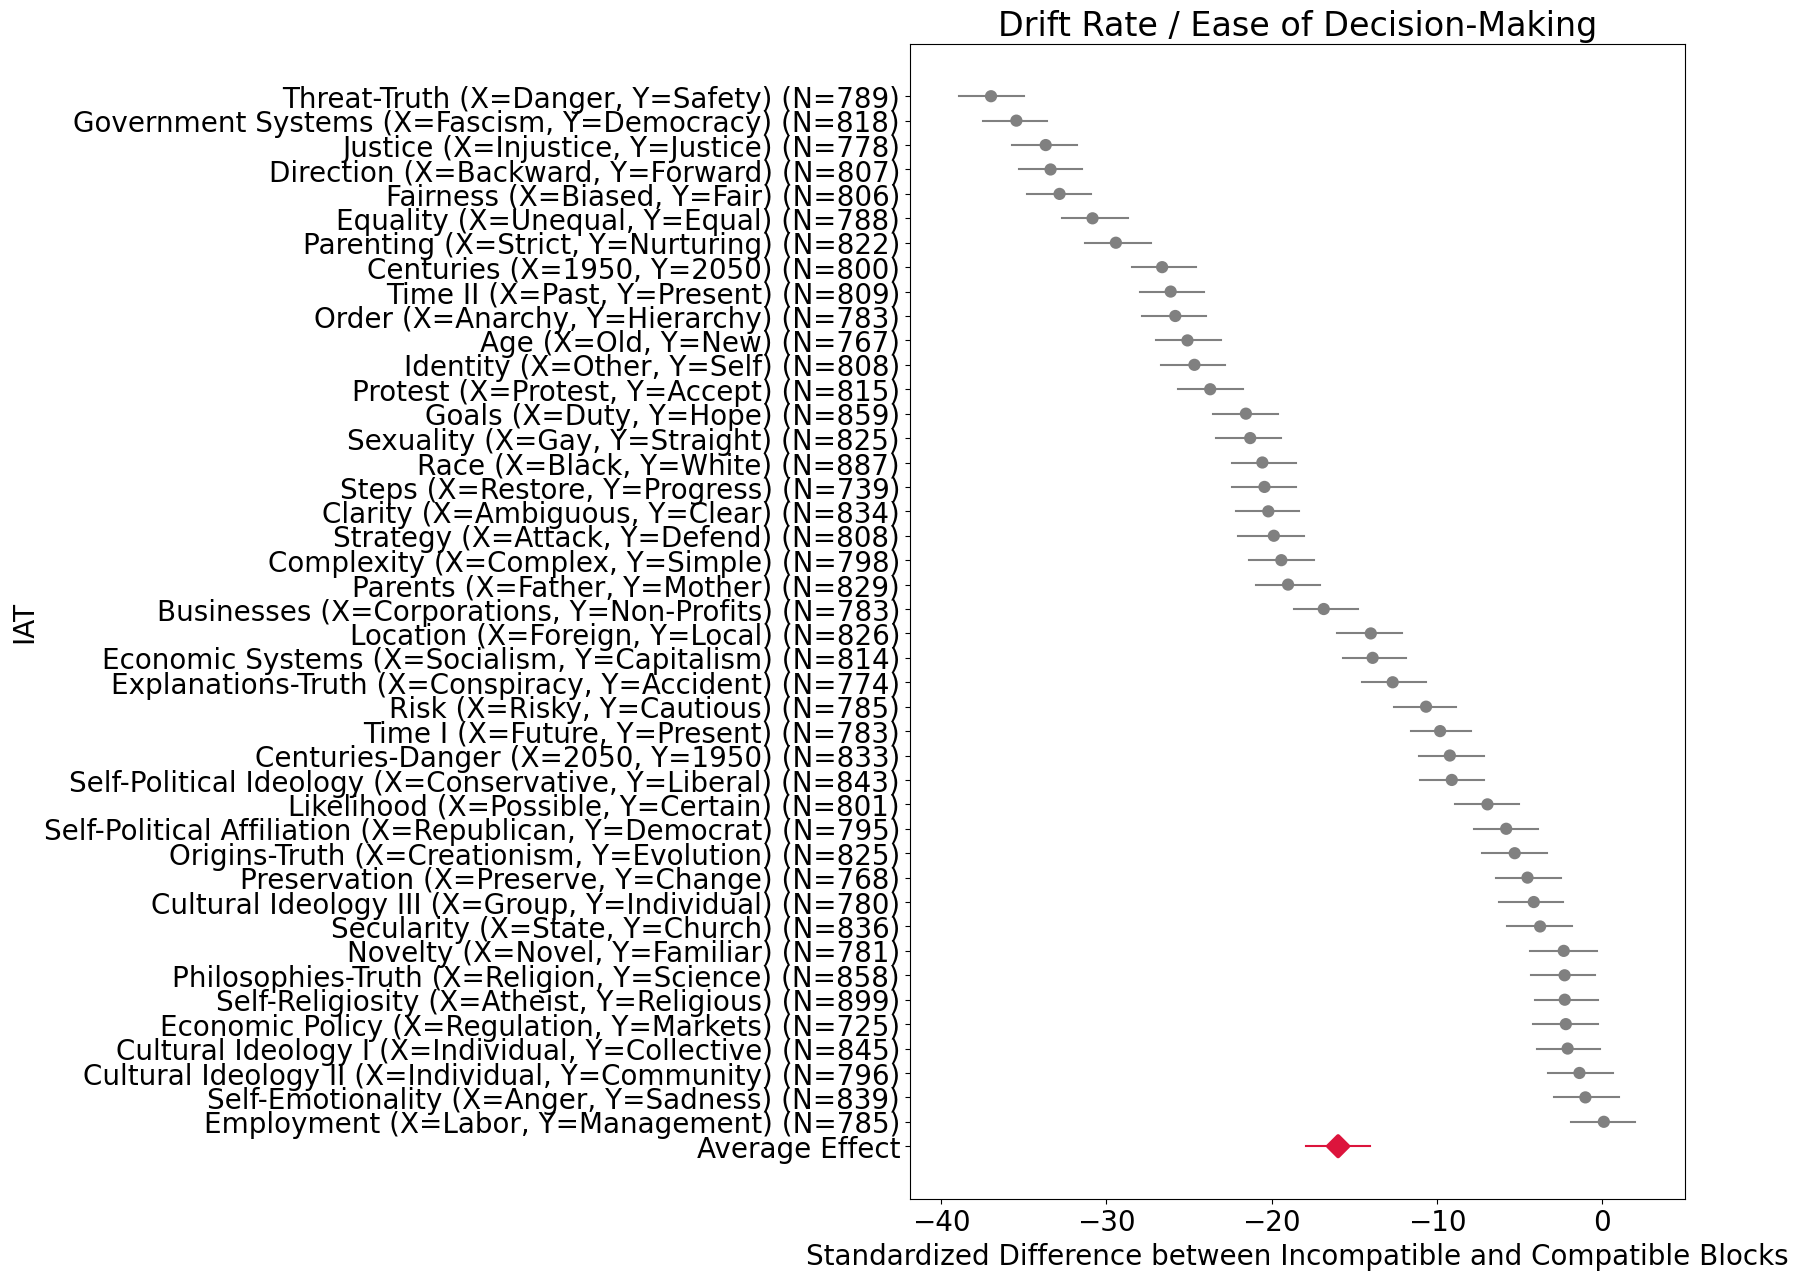

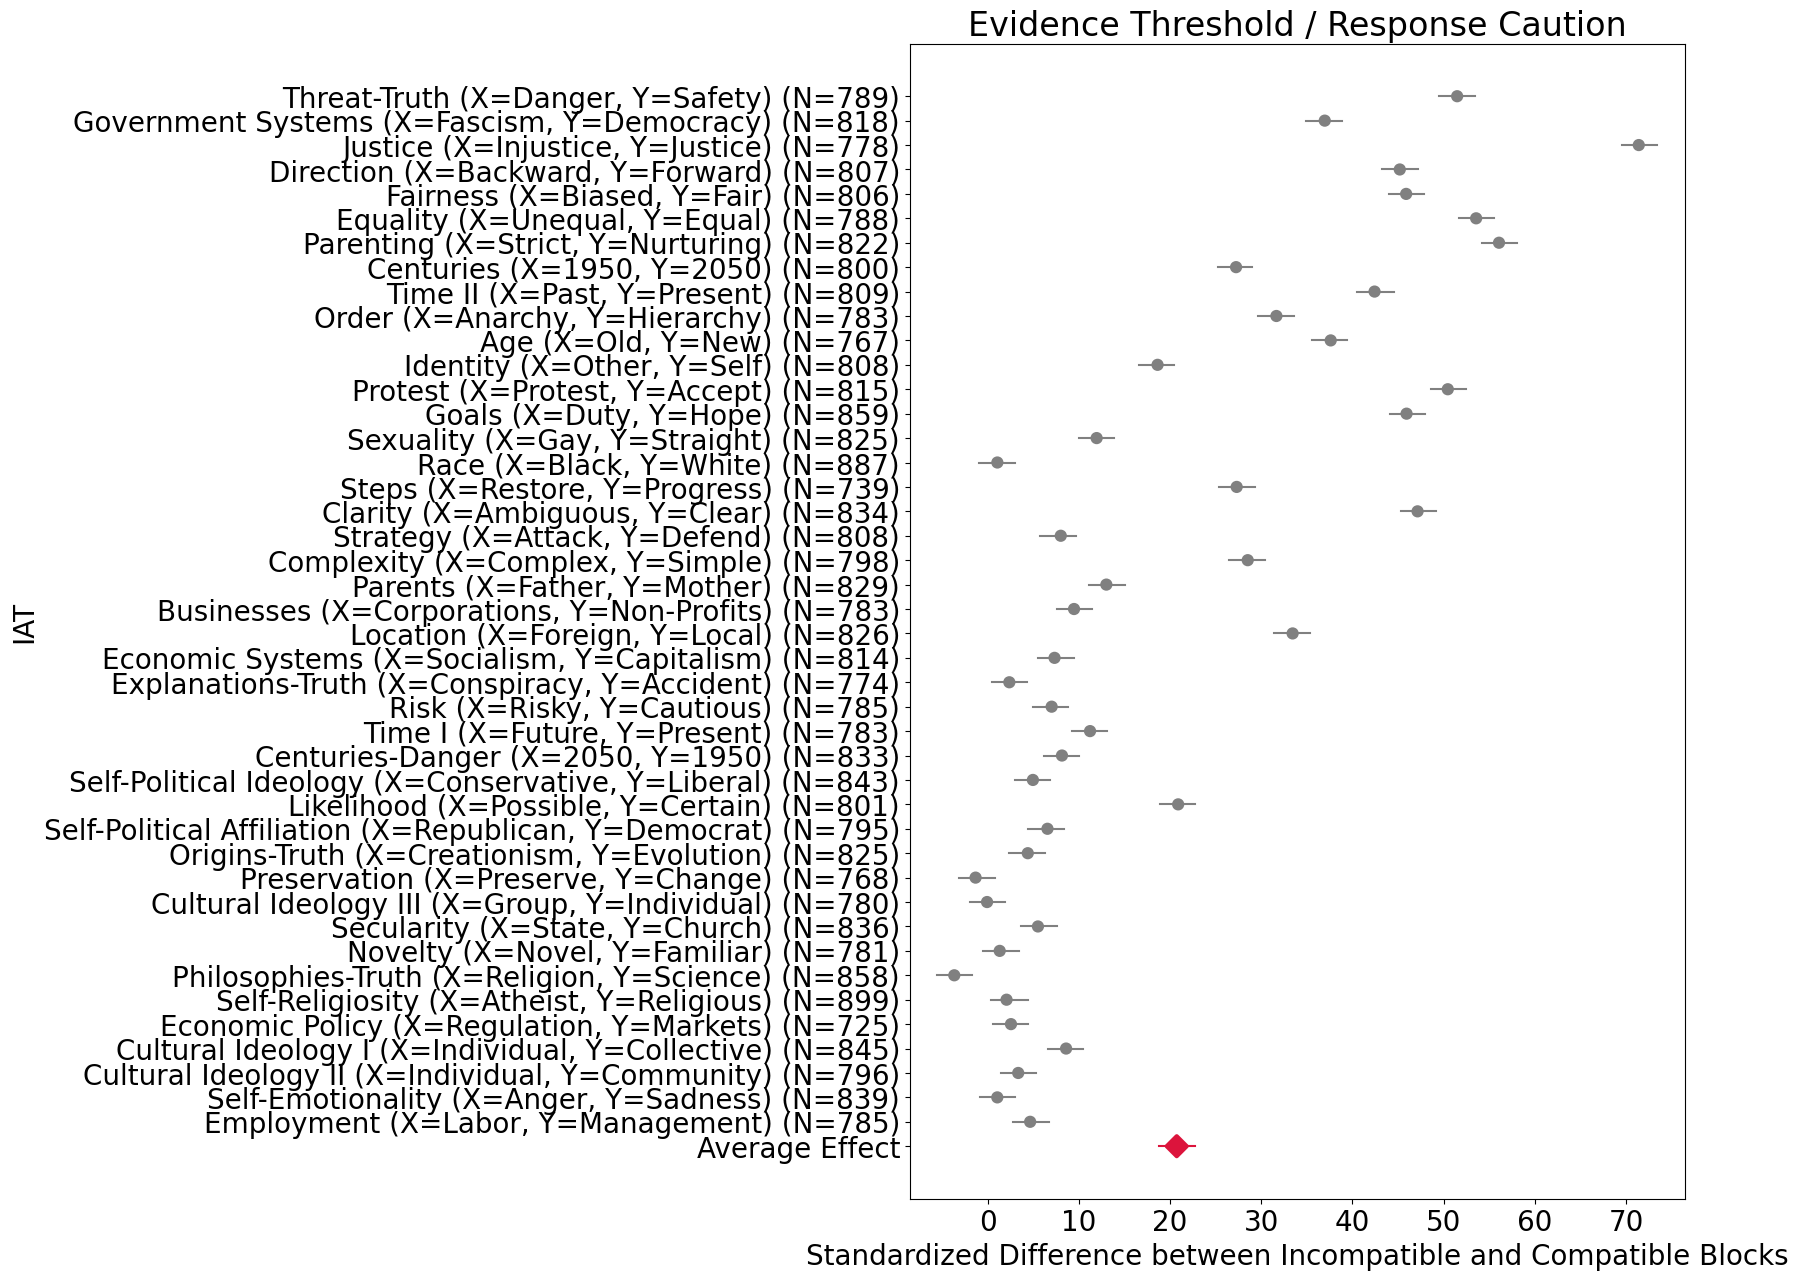

In [36]:
forestdf_list = [] # make a list of forest plots

for x in ['delta', 'alpha']: # first we'll go through the drift rates, then we'll go through the evidence thresholds

    nlist = [] # make a list of number of subjects included in the Stan model

    for i, iat in enumerate(list(block_dict.keys())): # loop through each IAT
        azdf = az_dict[iat] # get the Stan model result for an IAT
        if len(accumulator_b_dict[iat]) == 4: # if the IAT has 4 blocks (i.e., a standard IAT)
            cb=2; ib=3 # compatible block index
        else: # otherwise (i.e., a single-target IAT)
            cb=1; ib=2 # incompatible block index
        if x == 'delta': # extract drift rates from the Stan model result
            if iat not in ['defendattack', 'riskycautious']:
                compatible_accumulator_a = azdf.posterior['mu_v_upper'].stack(sample=('chain', 'draw')).sel({'mu_v_upper_dim_0': cb}).values
                compatible_accumulator_b = azdf.posterior['mu_v_lower'].stack(sample=('chain', 'draw')).sel({'mu_v_lower_dim_0': cb}).values
                incompatible_accumulator_a = azdf.posterior['mu_v_upper'].stack(sample=('chain', 'draw')).sel({'mu_v_upper_dim_0': ib}).values
                incompatible_accumulator_b = azdf.posterior['mu_v_lower'].stack(sample=('chain', 'draw')).sel({'mu_v_lower_dim_0': ib}).values
            else:
                compatible_accumulator_a = azdf.posterior['mu_v_upper'].sel({'mu_v_upper_dim_0': cb, 'chain': 0}).values
                compatible_accumulator_b = azdf.posterior['mu_v_lower'].sel({'mu_v_lower_dim_0': cb, 'chain': 0}).values
                incompatible_accumulator_a = azdf.posterior['mu_v_upper'].sel({'mu_v_upper_dim_0': ib, 'chain': 0}).values
                incompatible_accumulator_b = azdf.posterior['mu_v_lower'].sel({'mu_v_lower_dim_0': ib, 'chain': 0}).values
            compatible = (compatible_accumulator_a + compatible_accumulator_b) / 2 # get the average of the two drift rates for compatible
            incompatible = (incompatible_accumulator_a + incompatible_accumulator_b) / 2 # get the average of the two drift rates for incompatible
        else: # extract evidence thresholds from the Stan model result
            if iat not in ['defendattack', 'riskycautious']:
                compatible = azdf.posterior['mu_%s' % x].stack(sample=('chain', 'draw')).sel({'mu_%s_dim_0' % x: cb}).values
                incompatible = azdf.posterior['mu_%s' % x].stack(sample=('chain', 'draw')).sel({'mu_%s_dim_0' % x: ib}).values
            else:
                compatible = azdf.posterior['mu_%s' % x].sel({'mu_%s_dim_0' % x: cb, 'chain': 0}).values
                incompatible = azdf.posterior['mu_%s' % x].sel({'mu_%s_dim_0' % x: ib, 'chain': 0}).values
        difference = (incompatible - compatible) / np.std(incompatible - compatible)# get the standardized difference of the incompatible and compatible distributions
        
        # create a temporary dataframe with the mean of the standardized difference, IAT name, and 95% HDI
        tempdf = pd.DataFrame({'value': [np.mean(difference)],
                                'IAT': [xticks[iat]+" (N="+str(n_dict[iat])+")"],
                                'Upper': [az.hdi(difference, hdi_prob=0.95)[1]],
                                'Lower': [az.hdi(difference, hdi_prob=0.95)[0]]})

        nlist.append(n_dict[iat]) # append to nlist the total number of subjects for this IAT

        # create a larger dataframe concatenating together the temporary dataframes for each IAT
        # resulting in one dataframe with all mean standardized differences, IAT names, and 95% HDIs
        if i == 0:
            forestdf = tempdf.copy()
        else:
            forestdf = pd.concat([forestdf, tempdf])

    forestdf_list.append(forestdf.reset_index()) # append the final dataframe to a list that will have two total frames, one for average drift rate and another for evidence threshold

for j, fdf in enumerate(forestdf_list): # loop through the dataframes containing summarized drift rates and evidence thresholds
    fig, ax = plt.subplots(figsize=(10, 15))
    if j ==0: # if the first parameter, we need to sort ascending for graph, and save the index order for subsequent graphs
        ylist = []
        for i, mymodel in enumerate(list(block_dict.keys())):
            ylist.append([i, i]) # list of y values for plotting the HDIs
        ylist.append([i+1, i+1]) # add an extra y value for plotting the mean effect HDIs
        thisfdf = fdf.sort_values('value', ascending=True) # sort the summary stats for the IATs in ascending order
        oldindex = thisfdf.index # copy the index list of the ascending IATs
    else:
        thisfdf = fdf.copy().reindex(oldindex) # if not the first parameter, reindex the dataframe to match that of the first parameter

    # first we're only plotting the mean standardized differences for each IAT, but since we'll separately plot the average effect, we need to have an extra
    # y tick. So we'll add a final set of values to the dataframe that goes off the axis limit (won't see it, but it will create the extra tick for later)
    thisfdf_last = pd.DataFrame({'IAT': ['Average Effect'], 'value': [1000],
                            'Lower': [999], 'Upper': [1001]})
    final = pd.concat([thisfdf, thisfdf_last]) # add the extra y-tick to the end of the summary dataframe
    sns.pointplot(data=final, x='value', y='IAT', join=False, color=".5", markers="o", scale=1) # plot the mean effect for each IAT
    plt.plot(np.asarray(final[['Lower', 'Upper']]).T, np.asarray(ylist).T, color=".5") # plot the HDIs around each mean effect

    # now we can separately plot and overlay the average effect across IATs. Similar to before, we'll shift all the values we don't need off the axis limit.
    thisfdf2 = thisfdf.copy()
    thisfdf2['value']=thisfdf2['value']+1000
    thisfdf2['Lower']=thisfdf2['Lower']+1000
    thisfdf2['Upper']=thisfdf2['Upper']+1000
    # all we need is the average effect. Take the mean of the means and HDI bounds.
    thisfdf2_last = pd.DataFrame({'IAT': ['Average Effect'], 'value': [np.mean(thisfdf['value'])],
                            'Lower': [np.mean(thisfdf['Lower'])], 'Upper': [np.mean(thisfdf['Upper'])]})
    final = pd.concat([thisfdf2, thisfdf2_last])
    sns.pointplot(data=final, x='value', y='IAT', join=False, color="crimson", markers="D", scale=1.5) # plot the average effect across IATs
    plt.plot(np.asarray(final[['Lower', 'Upper']]).T, np.asarray(ylist).T, color="crimson") # plot the average HDI bounds across IATs

    if j==0:
        plt.xlabel("Standardized Difference between Incompatible and Compatible Blocks")
        plt.title('Drift Rate / Ease of Decision-Making')
    else:
        plt.xlabel("Standardized Difference between Incompatible and Compatible Blocks")
        plt.title('Evidence Threshold / Response Caution')
    plt.xlim(np.min(thisfdf['Lower'])-3, np.max(thisfdf['Upper'])+3)

In [42]:
model_dict = {}
# create dictionaries to store OLS results
dexp_dict = {}; fchange2_dict = {}; fchange1_dict = {}; eased_dict = {}; rcd_dict = {}; easeexp_dict = {}; rcexp_dict = {} 

for iat in list(block_dict.keys()):
    azdf = az_dict[iat] # get the Stan model result for an IAT
    modeldf = df_dict[iat].copy() # get the d-scores and explicit preferences. We'll add to this dictionary summary stats from the model for LMEs
    for x in ['alpha', 'v_upper', 'v_lower']:
        if x != 'tau':
            for y in range(4): # loop through each block
                if len(accumulator_b_dict[iat]) == 4: # if there are 4 blocks (i.e., a standard IAT), extract the mean estimate for each block
                    nsubs = len(azdf.posterior[x]['%s_dim_0' % x])/4
                    modeldf[x+str(y)] = azdf.posterior[x].mean(dim=['chain', 'draw']).sel({'%s_dim_0' % x: range(int(nsubs*y), int((nsubs*y)+nsubs))}).values
                elif len(accumulator_b_dict[iat]) == 2: # otherwise if a single-target IAT
                    if y == 0:
                        nsubs = len(azdf.posterior[x]['%s_dim_0' % x])/3
                        modeldf[x+str(y)] = azdf.posterior[x].mean(dim=['chain', 'draw']).sel({'%s_dim_0' % x: range(int(nsubs*y), int((nsubs*y)+nsubs))}).values
                    if y > 1:
                        nsubs = len(azdf.posterior[x]['%s_dim_0' % x])/3
                        modeldf[x+str(y-1)] = azdf.posterior[x].mean(dim=['chain', 'draw']).sel({'%s_dim_0' % x: range(int(nsubs*(y-1)), int((nsubs*(y-1))+nsubs))}).values

        else:
            modeldf[x] = azdf.posterior[x].mean(dim=['chain', 'draw']).values
    
    model_dict[iat] = modeldf

    print(iat)

    newdf = pd.DataFrame({'d': modeldf['d'], 'exp': modeldf['exp']}) # make a new dataframe with just the d-scores and explicit preference scores

    if len(accumulator_b_dict[iat]) == 4: # if the IAT has 4 blocks (i.e., a standard IAT)
        cb=2; ib=3 # indices for compatible and incompatible blocks
    else: # otherwise (i.e., a single-target IAT)
        cb=1; ib=2 # indices for compatible and incompatible blocks

    for x in ['alpha', 'mean_v']:
        if x == 'alpha':
            dif = modeldf['%s%s' % (x,ib)]-modeldf['%s%s' % (x,cb)] # get the difference in means between incompatible and compatible blocks for evidence threshold
        elif x == 'mean_v':
            dif = ((modeldf['v_lower%s' % ib]+modeldf['v_upper%s' % ib])/2)-((modeldf['v_lower%s' % cb]+modeldf['v_upper%s' % cb])/2) # same as above, but for drift rate, and we're taking the average of the two.
        newdf[x] = dif

    # Supplemental Aim: Predict explicit preference with D-scores
    model = ols("exp ~ d", st.mstats.zscore(newdf)).fit()
    print(model.summary())
    # add standardedized beta, 95% CIs, and number of observations to dictionary
    dexp_dict[iat] = [model.params[1], [model.conf_int()[0][1], model.conf_int()[1][1]], model.nobs]

    # Aim 2: Hierarchical regression
    biasmodel = ols("d ~ mean_v", st.mstats.zscore(newdf)).fit()
    biascautionmodel = ols("d ~ mean_v + alpha", st.mstats.zscore(newdf)).fit()
    print(biasmodel.summary())
    print(biascautionmodel.summary())

    # from the second model block, add the standardized betas, 95% CIs, and number of observations to dictionaries
    eased_dict[iat] = [biascautionmodel.params[1], [biascautionmodel.conf_int()[0][1], biascautionmodel.conf_int()[1][1]], biascautionmodel.nobs]
    rcd_dict[iat] = [biascautionmodel.params[2], [biascautionmodel.conf_int()[0][2], biascautionmodel.conf_int()[1][2]], biascautionmodel.nobs]
    
    # calculate the standard error in R2 for each model block, using number of observations, model degrees of freedom, and R2
    nobs = biasmodel.nobs
    k = 1
    r21 = biasmodel.rsquared
    ser21 = np.sqrt((4*r21*((1-r21)**2)*((nobs-k-1)**2))/((nobs**2-1)*(nobs + 3)))
    k = 2
    r22 = biascautionmodel.rsquared
    ser22 = np.sqrt((4*r22*((1-r22)**2)*((nobs-k-1)**2))/((nobs**2-1)*(nobs + 3)))
    
    # for each model block, add R2, SE bounds, number of observations, and F-change in comparison to first model block
    fchange2_dict[iat] = [r22, [r22-ser22, r22+ser22], biascautionmodel.nobs, biascautionmodel.compare_f_test(biasmodel)[1]]
    fchange1_dict[iat] = [r21, [r21-ser21, r21+ser21], biascautionmodel.nobs, biascautionmodel.compare_f_test(biasmodel)[1]]
    
    # Aim 3: Predict explicit preference with RDM params
    model = ols("exp ~ mean_v + alpha", st.mstats.zscore(newdf)).fit()
    print(model.summary())
    easeexp_dict[iat] = [model.params[1], [model.conf_int()[0][1], model.conf_int()[1][1]], model.nobs]
    rcexp_dict[iat] = [model.params[2], [model.conf_int()[0][2], model.conf_int()[1][2]], model.nobs]
    

possiblecertain
                            OLS Regression Results                            
Dep. Variable:                    exp   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     10.51
Date:                Fri, 21 Apr 2023   Prob (F-statistic):            0.00175
Time:                        01:18:47   Log-Likelihood:                -107.04
No. Observations:                  79   AIC:                             218.1
Df Residuals:                      77   BIC:                             222.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   6.939e-18      0.107   6

3014
0.2806005005993299
0.05210559064019367
0.5090954105584662


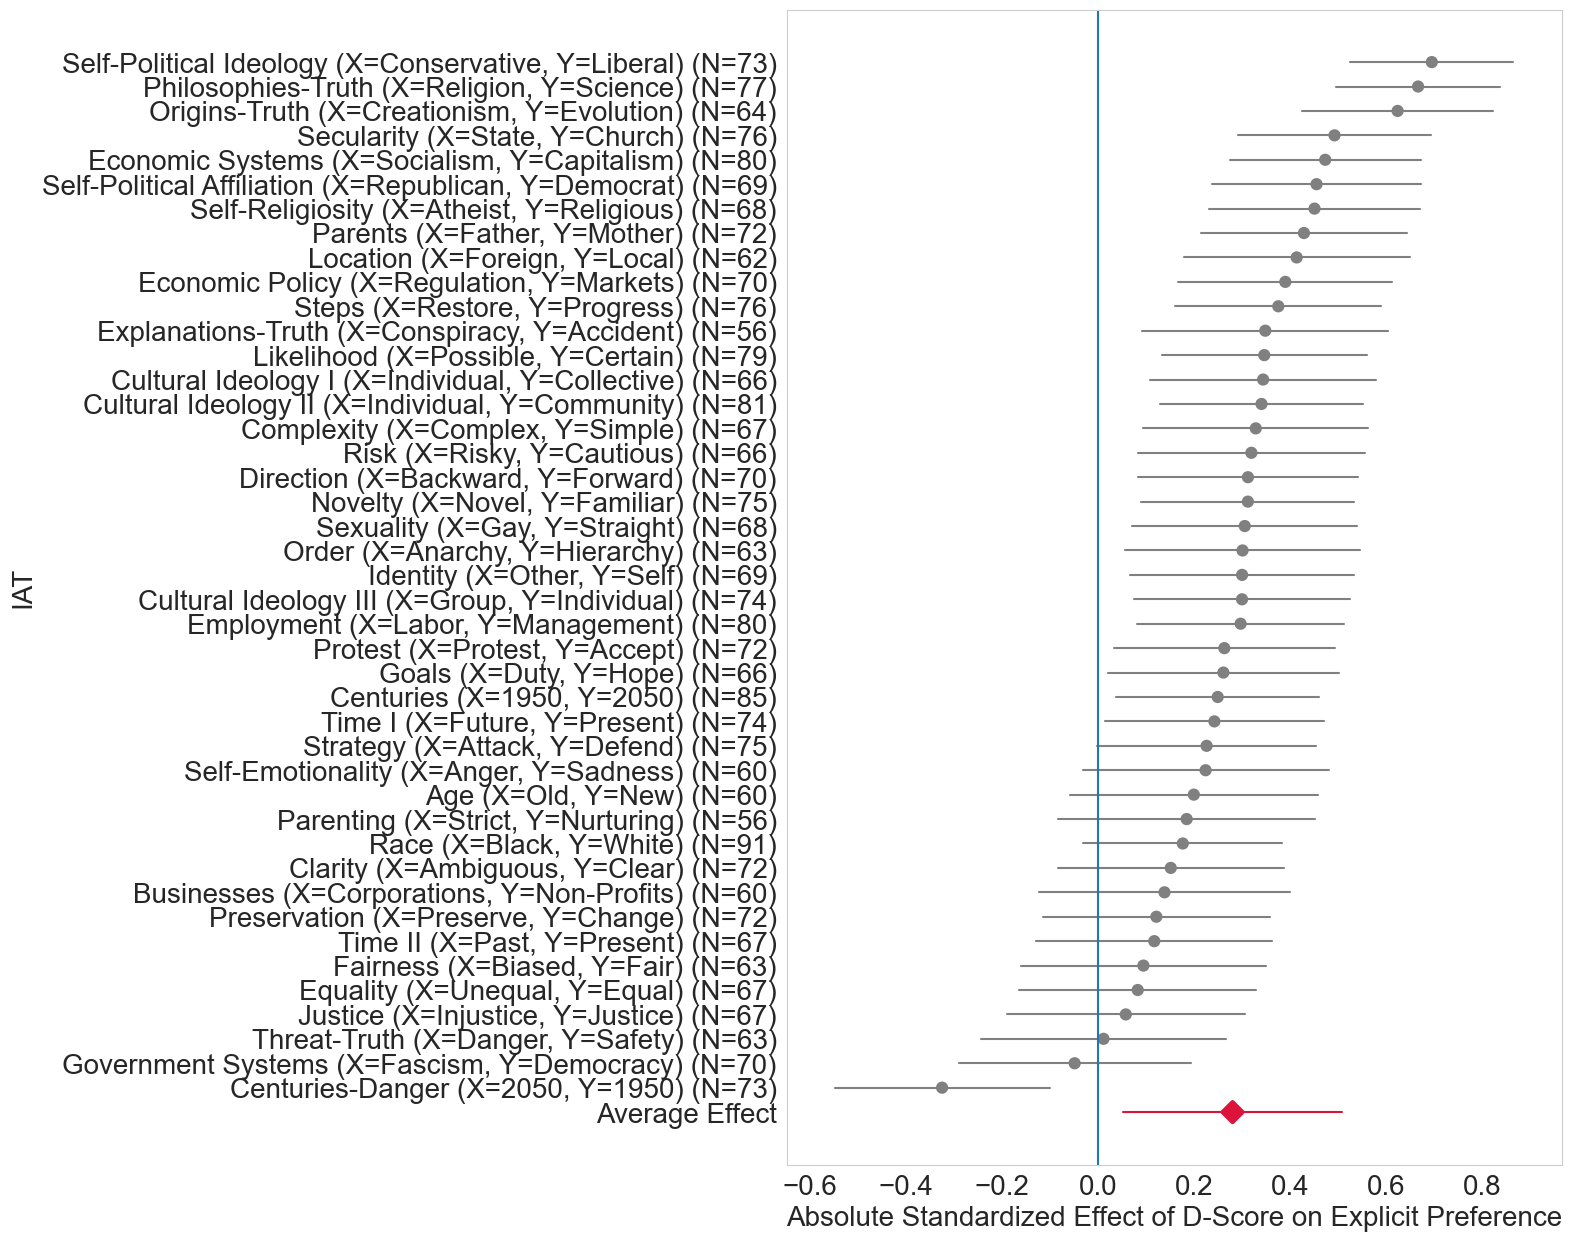

0
3014
0.8827944601316959
0.858459777231962
0.9071291430314294
1
3014
0.16894947149265613
0.09954205401512937
0.23835688897018287


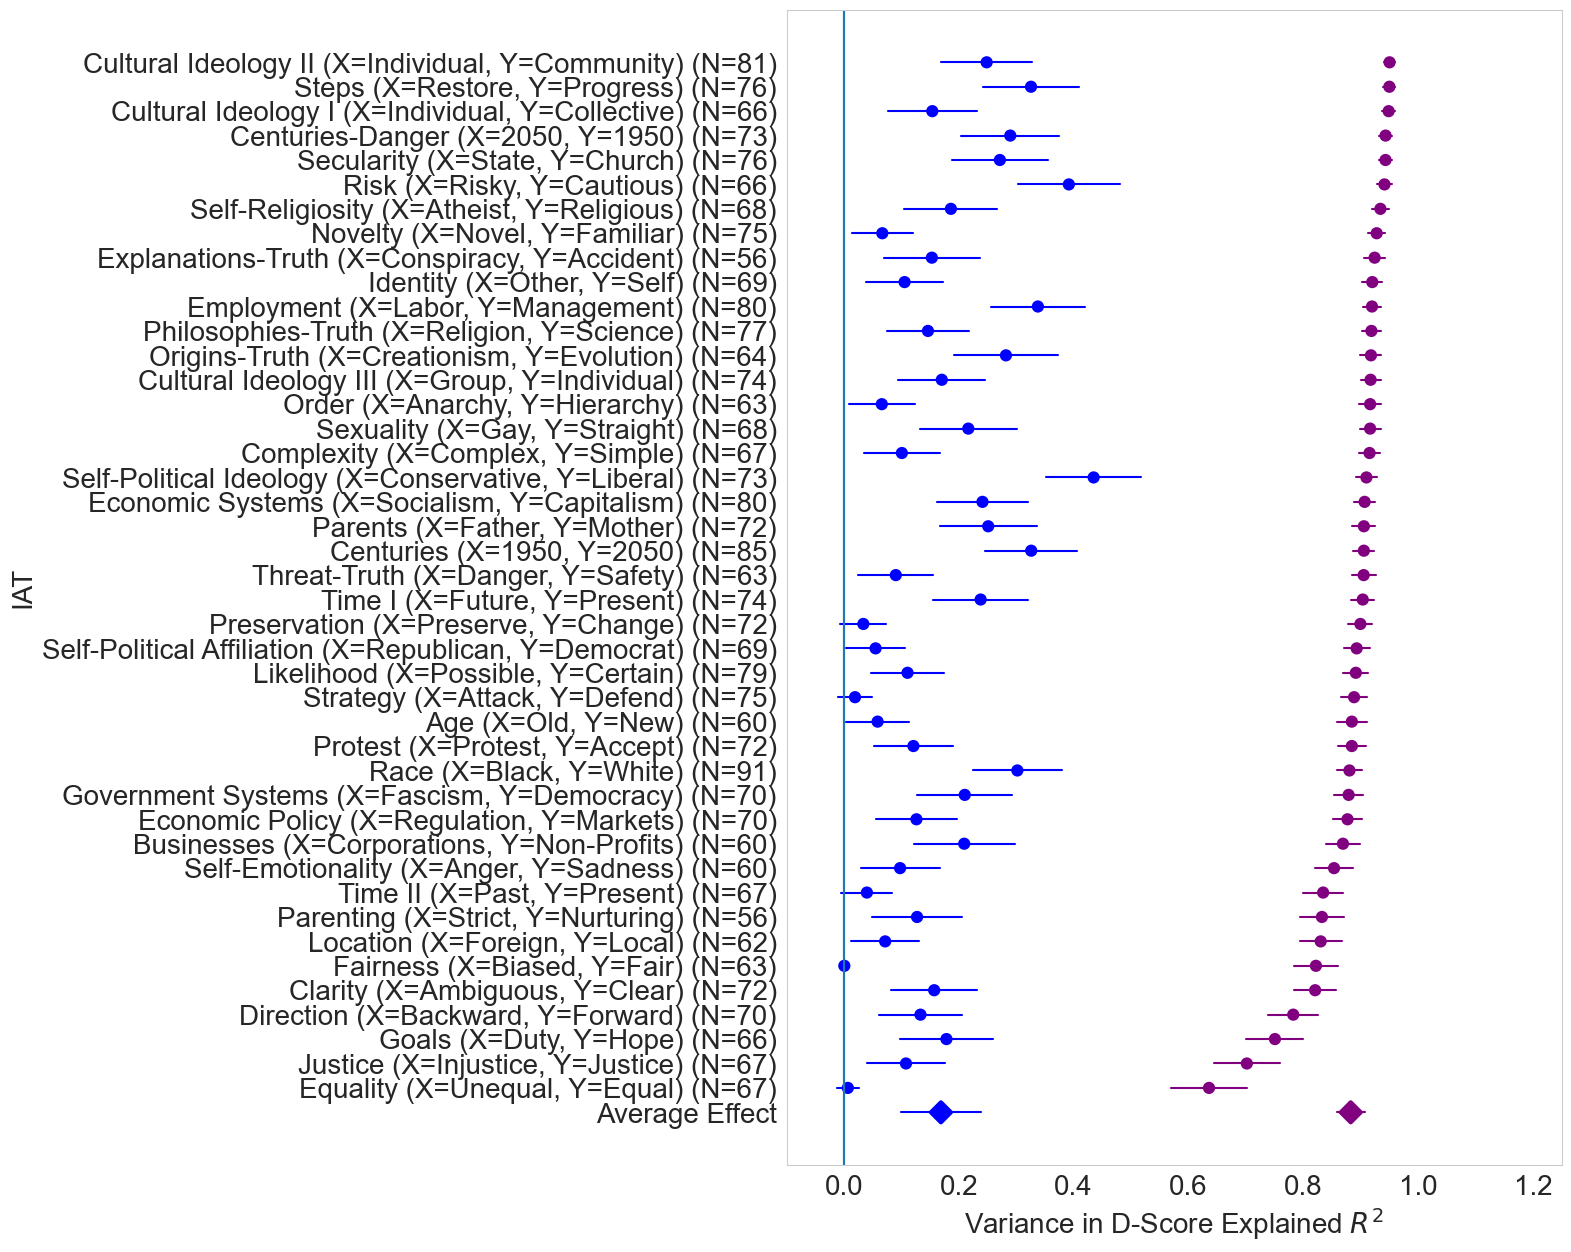

2
3014
0.8626649131282103
0.7791050570656496
0.9462247691907706
3
3014
0.5266234405347142
0.6101832965972744
0.4430635844721537


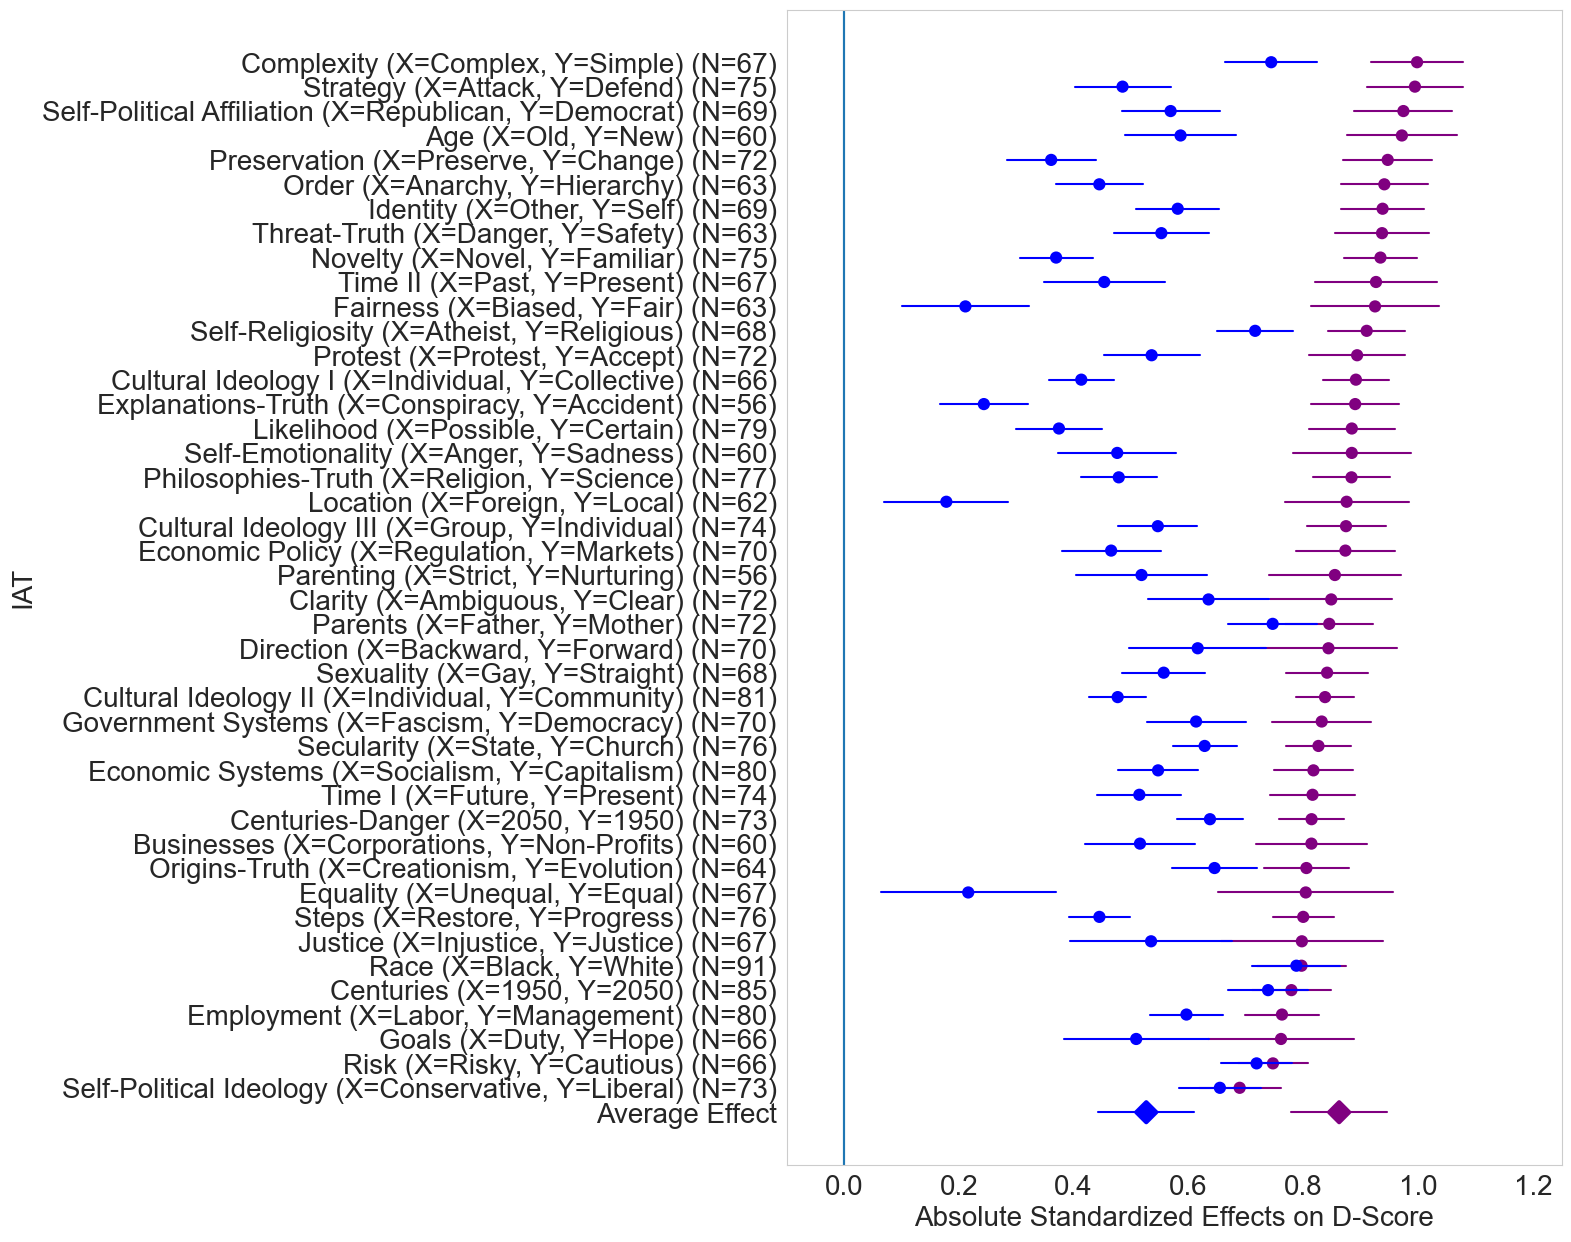

4
3014
-0.13058839480496465
-0.3658405326339953
0.10466374302406592


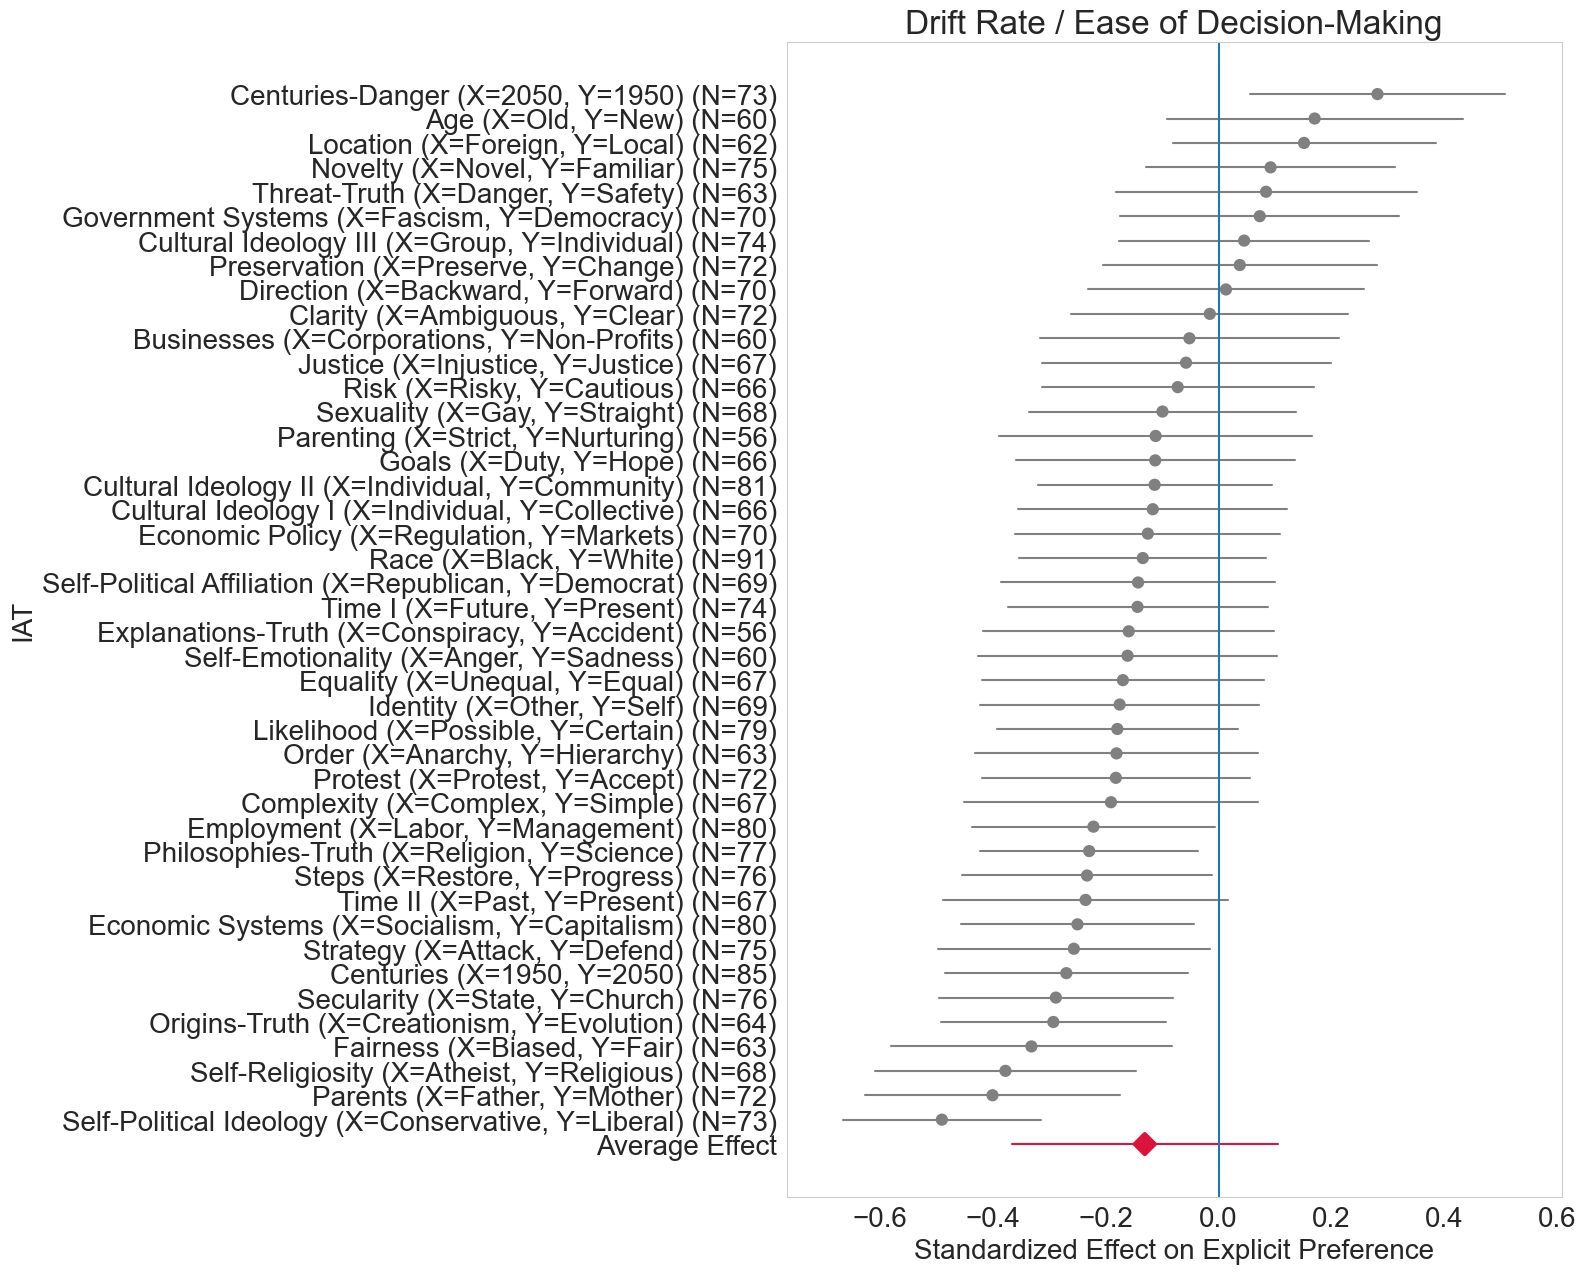

5
3014
0.24484585123882266
0.009593713409792077
0.4800979890678534


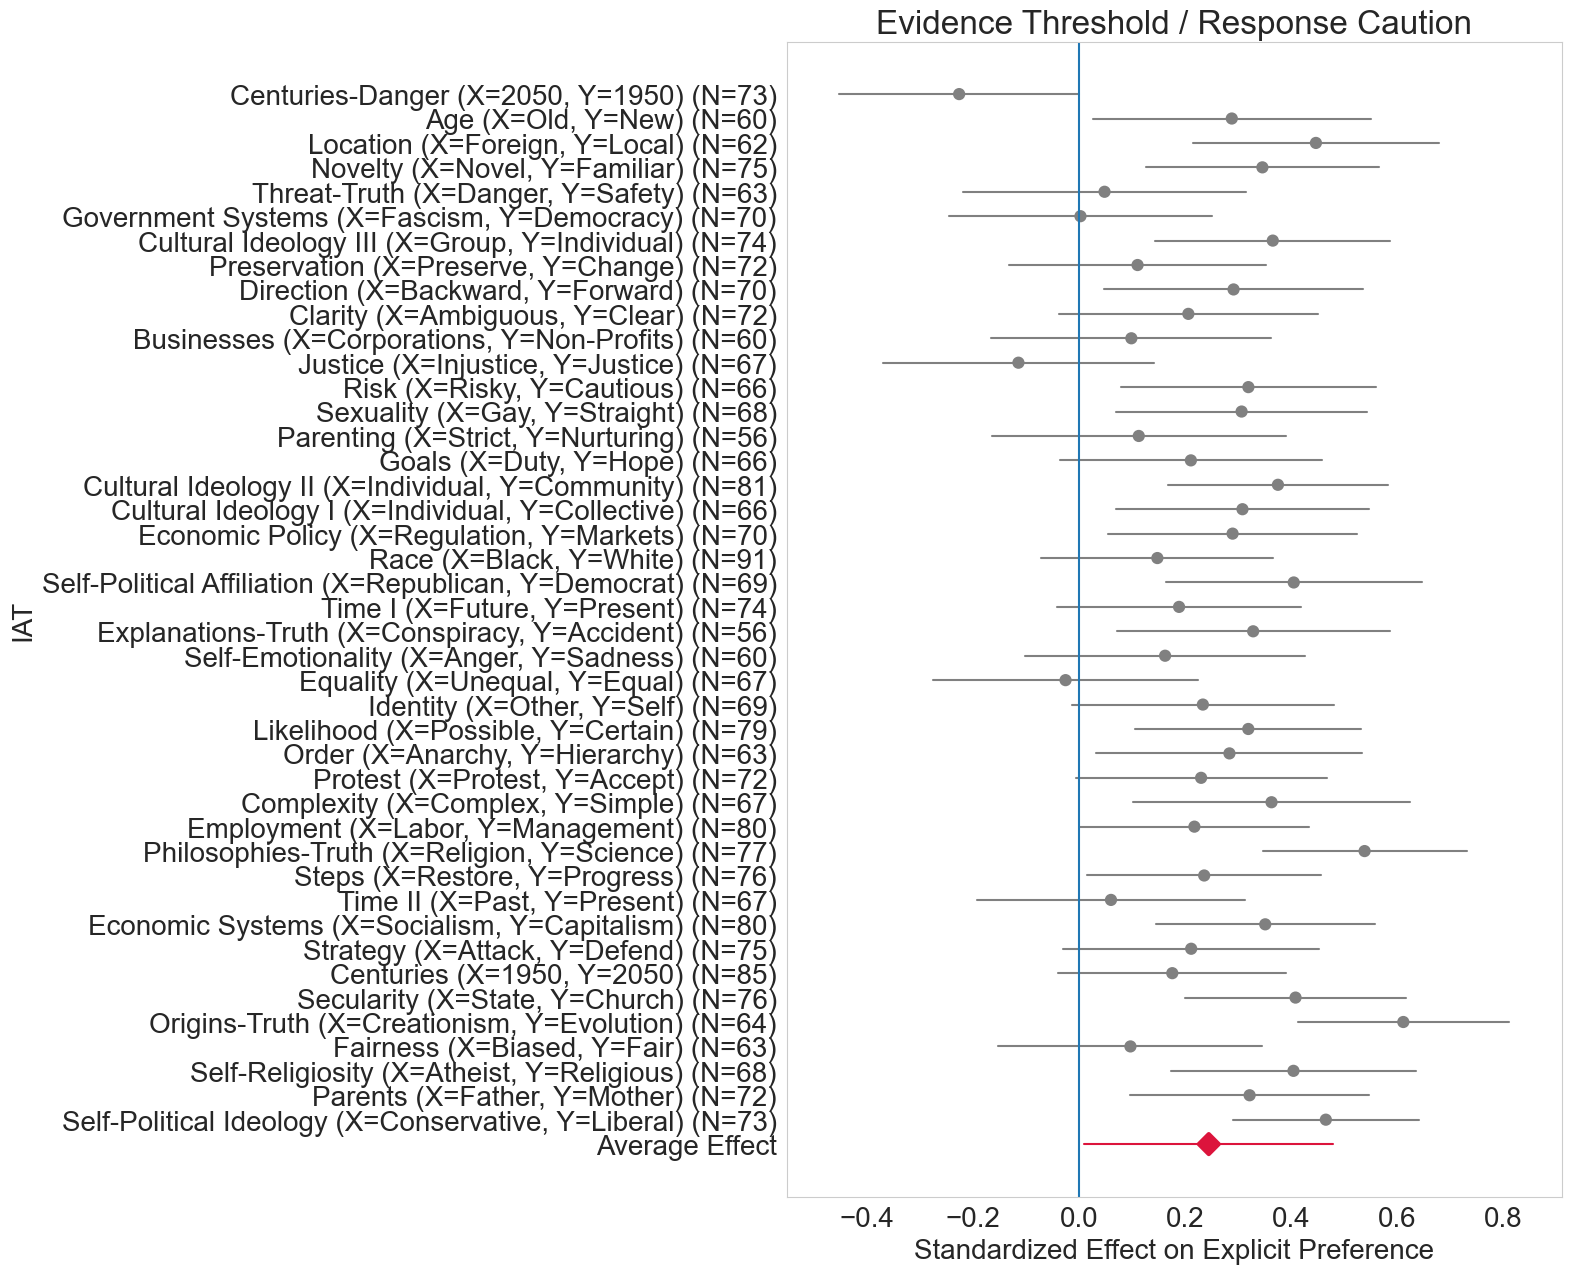

6


In [44]:
sns.set_style("whitegrid", {'axes.grid' : False})

xlist = []
for i, mymodel in enumerate(list(block_dict.keys())):
    xlist.append([i, i])
xlist.append([i+1, i+1])

dictlist = [dexp_dict, fchange2_dict, fchange1_dict, rcd_dict, eased_dict, easeexp_dict, rcexp_dict]
labellist = ["Absolute Standardized Effect of D-Score on Explicit Preference",
             "R2",
             r"Variance in D-Score Explained $R^{2}$",
             "Standardized Effect of Response Caution on D-Score",
             "Absolute Standardized Effects on D-Score",
             "Standardized Effect on Explicit Preference",
             "Standardized Effect on Explicit Preference"]
titlelist = ["",
             "",
             "",
             "",
             "",
             "Drift Rate / Ease of Decision-Making",
             "Evidence Threshold / Response Caution"]
nlist = []

for l, x in enumerate(dictlist):
    if l!=4 and l!=2:
        fig, ax = plt.subplots(figsize=(10, 15))

    pdiats = []; pdeffects = []; pdlower = []; pdupper = []
    for i in x.keys():
        pdiats.append(xticks[i]+" (N="+str(int(x[i][2]))+")")
        pdeffects.append(x[i][0])
        pdlower.append(x[i][1][0])
        pdupper.append(x[i][1][1])
        if l == 0:
            nlist.append(int(x[i][2]))
    print(np.sum(nlist))

    temp = pd.DataFrame({'IAT': pdiats, 'Effect': pdeffects,
                    'Lower': pdlower, 'Upper': pdupper})
    
    if l == 4:
        temp['Effect'] = temp['Effect']*(-1)
        temp['Lower'] = temp['Lower']*(-1)
        temp['Upper'] = temp['Upper']*(-1)
    if l != 7 and l != 8 and l != 9 and l != 6 and l != 4 and l != 2:
        temp = temp.sort_values('Effect', ascending=False)
        oldindex = temp.index
    else:
        temp = temp.reindex(oldindex)
    
    temp2 = pd.DataFrame({'IAT': ['Average Effect'], 'Effect': [1000],
                        'Lower': [999], 'Upper': [1001]})
    temp3 = pd.concat([temp, temp2])

    if l == 3 or l == 1:
        if l == 1:
            mylabel = "Ease of Decision-Making + Response Caution"
        else:
            mylabel = "Response Caution"
        mycolor = "purple"
    elif l == 4 or l == 2:
        if l == 2:
            mylabel = "Ease of Decision-Making Only"
        else:
            mylabel = "Ease of Decision-Making"
        mycolor = "blue" #"cerulean"
    else:
        mycolor = ".5"
        mylabel = ""

    sns.pointplot(data=temp3, x='Effect', y='IAT', join=False, color=mycolor, label=mylabel)
    plt.plot(np.asarray(temp3[['Lower', 'Upper']]).T, np.asarray(xlist).T, color=mycolor)

    temp4 = temp.copy()
    temp4['Effect']=temp4['Effect']+1000
    temp4['Lower']=temp4['Lower']+1000
    temp4['Upper']=temp4['Upper']+1000
    temp2 = pd.DataFrame({'IAT': ['Average Effect'], 'Effect': [np.mean(temp['Effect'])],
                        'Lower': [np.mean(temp['Lower'])], 'Upper': [np.mean(temp['Upper'])]})
    temp3 = pd.concat([temp4, temp2])
    print(np.mean(temp['Effect']))
    print(np.mean(temp['Lower']))
    print(np.mean(temp['Upper']))
    if l != 1 and l != 2 and l !=3 and l!=4:
        mycolor = "crimson"
    sns.pointplot(data=temp3, x='Effect', y='IAT', join=False, color=mycolor, markers="D", scale=1.5)
    plt.plot(np.asarray(temp3[['Lower', 'Upper']]).T, np.asarray(xlist).T, color=mycolor)
    plt.axvline(0, )
    plt.xlabel(labellist[l])
    plt.title(titlelist[l])

    if l == 4 or l == 2:
        plt.xlim(-.1, 1.25)
    else:
        plt.xlim(np.min(temp['Lower'])-0.1, np.max(temp['Upper'])+0.1)
    if l !=3 and l !=1:
        plt.show()
    print(l)

